In [2]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.stats import binned_statistic_2d
import Ian_functions as load
import pandas as pd
from scipy import signal
from scipy import fftpack as ff
from astropy import wcs
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'
old_path = '2012_data/'
bolo_path = '2012_data/bolo_data/'

In [3]:
reload(load);

In [4]:
#loads the data in, third argument is the file type u16 is uint16 u32 is uint32 and s32 is signed int32
ra = load.loadArbData(old_path, 'ra', 'u32')
dec = load.loadArbData(old_path, 'dec', 's32')
bolo = load.loadArbData(bolo_path, 'n26c04', 'u32')

In [5]:
# linear conversion values for data
ra_a =  5.587935447693e-09
ra_b = 0
dec_a = 8.381903171539e-08
dec_b = 0
bolo_a = 6.903363270000e-07
bolo_b = -5.787153550000e+00

In [6]:
# conversion from dirfiles to useful data
bolo = bolo_a*bolo + bolo_b
ra = ra*ra_a
dec = dec*dec_a

In [7]:
# start of setting plotting ranges, probably should interpolate the data to bring ra dec to 100hz from 5hz
#bolo_start = 20*3652830
#bolo_range = 129450*20
#slow_range = 129450
#slow_start = 3652830
#arb range 8.4 days into flight, post SC failure, try new one below
# arbitrary range I created. seems to contain a scan?
#bolo_start = 20*(1603980-50000)
#bolo_range = 285000*20
#slow_range = 285000
#slow_start = 1603980-50000
#above looks to be a vela c scan, finding more
#bolo_start = 20*(269940)
#bolo_range = 29520*20
#slow_range = 29520
#slow_start = 269940
#above is probably carina nebula
bolo_start = 20*(269940)
bolo_range = 29520*20
slow_range = 29520
slow_start = 269940
#useful ranges of things found in the data, in index values

In [8]:
def filt_gabs(f, f1):
    if f < .5*f1:
        return 0
    elif 0.5*f1 < f  and f < f1:
        return 0.5-0.5*np.cos(np.pi*(f-0.5*f1)*(f1-0.5*f1)**-1)
    elif f > f1:
        return 1

In [9]:
fs = 100
cutoff = 2
filt_bolo = load.butter_highpass_filter(bolo[bolo_start+1:bolo_start+bolo_range-1], cutoff, fs)

//anaconda/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [10]:
#set up the interpolation indices
t5 = np.arange(len(ra))/5.
t100 = np.arange(len(bolo))/100.

In [11]:
#interpolate ra and dec to 100hz from 5hz
ra_int = interp1d(t5[slow_start:slow_start+slow_range+1], ra[slow_start:slow_start+slow_range+1], kind='linear')
dec_int = interp1d(t5[slow_start:slow_start+slow_range+1], dec[slow_start:slow_start+slow_range+1], kind= 'linear')

In [12]:
#generate new arrays for time for the interpolated data
t100_use = t100[bolo_start+1:bolo_start+bolo_range-1]
t5_use = t5[slow_start:slow_start+slow_range]

In [13]:
#generate new arrays of interpolated data to match the bolometer data
dec_100 = dec_int(t100[bolo_start+1:bolo_start+bolo_range-1])
ra_100 = ra_int(t100[bolo_start+1:bolo_start+bolo_range-1])

In [14]:
# convert ra to degrees from hours in order to 
ra_100_deg = load.ra_to_deg(ra_100);

In [15]:
#binned_bolo, size = load.arb_binning(ra_100_deg, dec_100, filt_bolo[bolo_start+1:bolo_start+bolo_range-1], .01166)
#hard coded the bin size so that each detection should be put in a 3x3 array around it

In [16]:
ra_dec_array = load.ra_dec_to_array(ra_100_deg, dec_100)

In [17]:
w = wcs.WCS(naxis=2)

In [113]:
w.wcs.crpix = [0, 0]
w.wcs.cdelt = np.array([0.033333, 0.033333])
w.wcs.crval = [158, -60.5]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.set_pv([(2, 1, -61)])

In [114]:
world = w.wcs_world2pix(ra_dec_array, 1)

In [115]:
clean, size = load.clean_up_world(world)

In [133]:
sort = load.sort_bolo(defft,clean,size, 0)

In [119]:
header = w.to_header()

In [120]:
hdu = fits.PrimaryHDU(sort, header=header)

In [135]:
#hdu.writeto('test.fits')

In [122]:
hdu_handler = fits.open('test.fits')

In [123]:
hdu_handler.info()

Filename: test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      20   (160, 84)   float64   


<IPython.core.display.Javascript object>


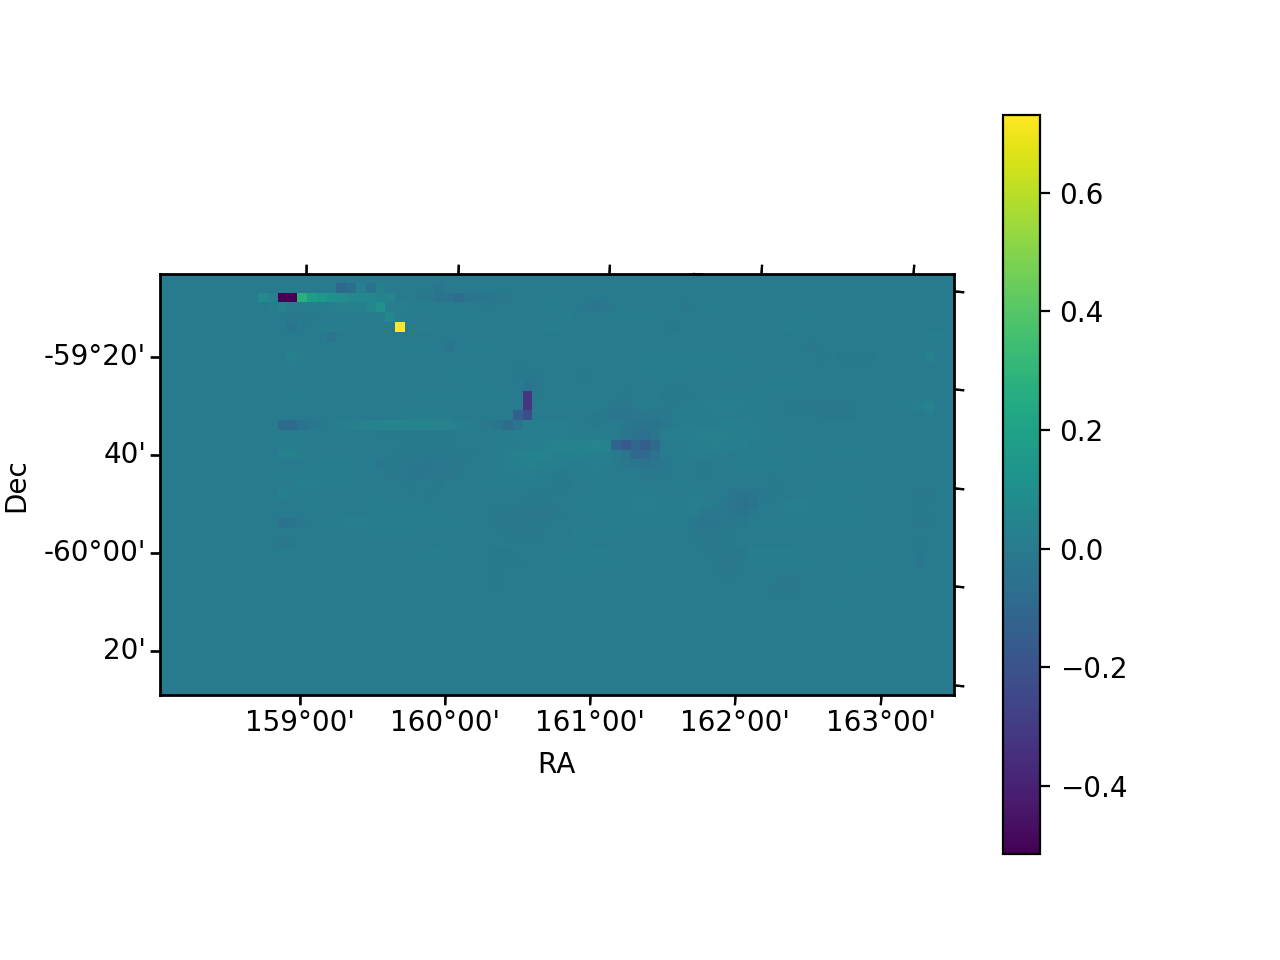

In [134]:
%matplotlib notebook
fig = plt.figure()
fig.add_subplot(111, projection=w)
plt.imshow(sort, origin='lower', cmap=plt.cm.viridis)
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')

In [ ]:
plt.plot(bolo[bolo_start+1:bolo_start+bolo_range-1])

In [ ]:
hdu_handler.close()

In [23]:
#fft and filter the data as per gabs request
fftbolo = np.fft.rfft(bolo[bolo_start+1:bolo_start+bolo_range-1])

In [24]:
fftbolo

array([ 9.76223391e+05+0.00000000e+00j,  1.61051756e+03-1.62707832e+03j,
       -4.29146627e+02-6.95938989e+02j, ...,
        1.72835224e-02+1.18680704e-04j,  1.72881003e-02+1.15875232e-04j,
        1.75221167e-02+0.00000000e+00j])

In [25]:
fftfreqs = np.fft.rfftfreq(np.size(bolo[bolo_start+1:bolo_start+bolo_range-1]),0.01)

In [26]:
vect = np.vectorize(filt_gabs)

In [27]:
vect_array = vect(fftfreqs, .2)

In [28]:
conv = vect_array*fftbolo

//anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


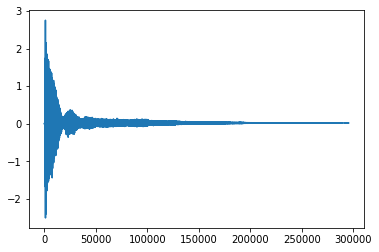

In [29]:
#conv2 = np.append(conv,np.flip(conv))
plt.plot(conv)

In [30]:
defft = np.fft.irfft(conv)

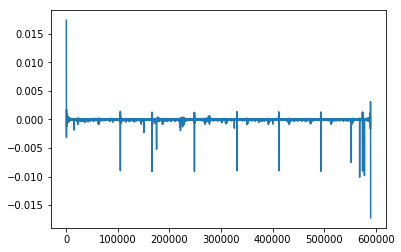

In [31]:
plt.plot(defft)

In [63]:
print defft[1000]-defft[len(defft)-1000]

0.002362616385786053
